In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tqdm
import dill
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
class CalculateDelta(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X[:-1] - X[1:]

In [4]:
class Quantizer(TransformerMixin):
    def __init__(self, quantization_channels=2**8, oov_token=-1):
        self.quantization_channels = quantization_channels      # Quantization channels includes oov (= quantization_channels - 1 + 1)
        self.oov_token = oov_token
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        mask = pd.Series(X).value_counts()[self.quantization_channels-1:].index     # Only include categories in top {quantization_channels - 1} occurence
        noise_index = np.where(np.isin(X, mask))
        X[noise_index] = self.oov_token
        return X

In [5]:
class SparseCategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, oov_token=-1):
        self.oov_token = oov_token

    def fit(self, X, y=None):
        X_counts = pd.Series(X).value_counts()
        self.vocab_size = len(X_counts)
        self.word_index = X_counts.index
        self.vocabulary = {X_counts.index[i]:i for i in range(self.vocab_size)}
        
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for i in range(len(X)):
            if X[i] in self.word_index:
                X_transformed.append(self.vocabulary[X[i]])
            else:
                X_transformed.append(self.vocabulary[self.oov_token])

        return np.array(X_transformed)

    def inverse_transform(self, X, y=None):
        return np.array([self.word_index[X[i]] for i in range(len(X))])

In [6]:
dataset_name = "GEMM_Wavenet"

In [7]:
# Parameters
quantization_channels = 2**16
#receptive_field = 257

In [8]:
original_dataset = pd.concat([pd.read_csv("../로그 데이터/GEMM/gem_3214_generic_{}.csv".format(i), dtype=np.object) for i in reversed(range(1, 11))], axis=0)
original_dataset = original_dataset[["gpa", "rip"]].dropna()       # rip for PCs

In [9]:
original_dataset

,gpa,rip
0,14190604288,15410752
1,14352732392,140316942991300
2,14121463808,15410776
3,14120734720,15410764
4,14120828928,15410764
...,...,...
400591,8620549134,18446744071888380942
400592,22541025656,18446744071888380942
400593,8620549134,18446744071888380942
400594,8620548801,18446744071888380609


In [10]:
# Split gpa and rip and calcualte Delta : As np.subtract erroneously broadcasts elements
gpa = original_dataset["gpa"].values.astype(np.float64)
rip = original_dataset["rip"].values.astype(np.uint64)

#dataset = np.c_[gpa_delta, rip_delta]

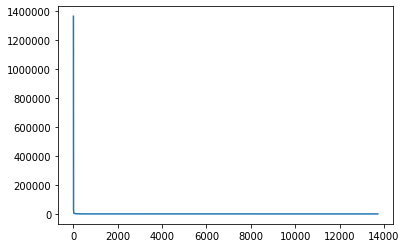

In [15]:
from matplotlib import pyplot as plt

plt.plot(pd.Series(rip[:-1] - rip[1:]).value_counts().values)

In [16]:
pd.Series(rip[:-1] - rip[1:]).value_counts()

0                       1365072
18446744073709551604     136986
18446744073709551605      74210
35                        65567
12                        45805
                         ...   
93942167534392                1
18446604260086020165          1
18446649989841433293          1
140459527662587               1
18446603631421424191          1
Length: 13724, dtype: int64

In [18]:
rip

array([            15410752,      140316942991300,             15410776,
       ..., 18446744071888380942, 18446744071888380609,
       18446744071888380609], dtype=uint64)

In [17]:
pd.Series(gpa[:-1] - gpa[1:]).value_counts()

-4.096000e+03    630464
 0.000000e+00    179166
-1.638400e+06     94680
-1.896448e+06     41872
-4.060000e+03     13676
                  ...  
-1.305838e+09         1
 5.100828e+06         1
 1.305793e+09         1
-1.305739e+09         1
-7.084808e+08         1
Length: 303888, dtype: int64

In [13]:
r = 0
for i, vc in enumerate(pd.Series(gpa).value_counts()):
    print(i, vc)
    if i == 64: break
    r += vc
r

0 27646
1 13822
2 8452
3 7370
4 6912
5 6912
6 6911
7 6755
8 6300
9 6048
10 5787
11 5623
12 5332
13 5226
14 4667
15 4152
16 4116
17 3540
18 3246
19 3056
20 2914
21 2736
22 2428
23 2304
24 2257
25 2224
26 2170
27 2123
28 2113
29 2095
30 1810
31 1506
32 1363
33 1363
34 1363
35 1219
36 1101
37 909
38 862
39 743
40 688
41 668
42 655
43 655
44 655
45 655
46 607
47 455
48 308
49 260
50 243
51 205
52 174
53 152
54 139
55 100
56 86
57 85
58 84
59 68
60 62
61 54
62 53
63 51
64 50


184638

In [ ]:
# Train / Val / Test Ratio : 70% / 15% / 15%
gpa_train_val_set, gpa_test_set = train_test_split(gpa, test_size=0.15, shuffle=False)
rip_train_val_set, rip_test_set = train_test_split(rip, test_size=0.15, shuffle=False)
#train_set, val_set = train_test_split(train_val_set, test_size=0.2, shuffle=False)

In [14]:
gpa_pipeline = Pipeline([
    ('calculate_delta', CalculateDelta()),
    ('noise_tokenizer', NoiseTokenizer(quantization_channels=quantization_channels)),
    ('sparse_category_encoder', SparseCategoryEncoder())
])

rip_pipeline = Pipeline([
    ('calculate_delta', CalculateDelta()),
    ('noise_tokenizer', NoiseTokenizer(quantization_channels=quantization_channels)),
    ('sparse_category_encoder', SparseCategoryEncoder())
])

In [15]:
processed_train_val_set = pipeline.fit_transform(train_val_set)
processed_test_set = pipeline.transform(test_set)

In [ ]:
np.savetxt("data/{}_train_set_original.csv".format(model_name), train_set, fmt="%d", delimiter="\n")
np.savetxt("data/{}_test_set_original.csv".format(model_name), test_set, fmt="%d", delimiter="\n")

np.savetxt("data/{}_train_set.csv".format(model_name), processed_train_set, fmt="%d", delimiter="\n")
np.savetxt("data/{}_val_set.csv".format(model_name), processed_val_set, fmt="%d", delimiter="\n")

In [ ]:
validation_set = np.r_[train_set[-1], val_set]  # As one data point is lost during CalculateDelta process
np.savetxt("data/{}_val_set_original.csv".format(model_name), validation_set, fmt="%d", delimiter="\n")

In [ ]:
processed_dataset = tf.data.Dataset.from_tensor_slices(dataset_delta).window(receptive_field, 1, 1, True)

processed_dataset_numpy = []

for d in tqdm.tqdm(processed_dataset):
    processed_dataset_numpy.append(np.c_[[p for p in d.as_numpy_iterator()]])